In [1]:
%config Completer.use_jedi = False # in case your autocomplete does not work

What we did in the previous article does not follow a best practice. 
For example, I use the test set to do validation. 
I should randomly split the training set into a training set and a validation set.
This is just one example of me being lazy and not following the best engineering practice to conduct a ML study.
The other example is that I should store the optimal weights. 
There is a pattern in dealing with this problem, i.e., using a framework.
For PyTorch, the go-to framework is PyTorch Lightning (PL). 
The goal of PL is to separate the engineering practice and the research practice.
It automates the engineering practice, i.e., split a dataset, prepare a test set, calculate accuracy (we only calculate loss before), logging, move computation to GPUs or TPUs etc. 
We will use PL to redo our previous activity.

# PyTorch Lightning

To put it simply, PL is a wrapper of nn.Module of PyTorch. 
That is, PL adds more methods.
In addition to init and forward, we should add (a common practice in PL):

- training_step: self explanatory
- validation_step: self explanatory
- test_step: self explanatory
- configure_optimizer: self explanatory
- prepare_data: download dataset once (if needed)
- setup: load dataset, transform, split data, copy data to GPUs, etc
- train_dataloader: self explanatory
- val_dataloader: self explanatory
- test_dataloader: self explanatory


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pytorch_lightning as pl # --> NEW
from torchvision import datasets, transforms
from torchmetrics.functional import accuracy
# from pytorch_lightning.metrics.functional import accuracy # --> This is NEW
from torch.utils.data import DataLoader, random_split # random_split is NEW

import sps # from https://github.com/IssamLaradji/sps --> a new optimizer

if you learn a framework, IMHO it's better to see examples from the framework creator.
For this tutorial, I follow: 

https://colab.research.google.com/github/PytorchLightning/pytorch-lightning/blob/master/notebooks/01-mnist-hello-world.ipynb#scrollTo=Mb0U5Rk2kLBy 



In [3]:
class FNN(pl.LightningModule):
    
    def __init__(self, input_size, num_neurons_hidden1,  num_neurons_hidden2, output_size, optimizer='adam'):
        # Copy paste from the previous article
        super().__init__()
        self.input_layer = nn.Linear(input_size,num_neurons_hidden1)
        self.hidden_layer1 = nn.Linear(num_neurons_hidden1,num_neurons_hidden2)
        self.output_layer = nn.Linear(num_neurons_hidden2,output_size)
        
        tf_resize = transforms.Resize((28,28)) # make sure that all loaded images have these dimensions
        tf_totensor = transforms.ToTensor() # Why? pytorch uses this datatype
        tf_normalize = transforms.Normalize(mean=(.5,),std=(.5,)) # this is rather tricky to explain. I'll explain it after we compose all these transformations

        self.tf_compose = transforms.Compose([tf_resize,tf_totensor,tf_normalize])
        
        self.optimizer = optimizer
        
    def forward(self,x):
        # Copy paste from the previous article
        y = nn.functional.relu(self.input_layer(x))
        y = nn.functional.relu(self.hidden_layer1(y))
        y = self.output_layer(y)
        return y
    
    def training_step(self, batch, batch_idx):
        # Copy paste from the previous article
        inputs, labels = batch
        inputs = inputs.view(inputs.shape[0],-1)
        
        outputs = self.forward(inputs)
        loss = nn.functional.cross_entropy(outputs,labels) # --> NEW. Using nn.CrossEntropyLoss
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        # This is new, but the structure is the same as training_step
        inputs, labels = batch
        inputs = inputs.view(inputs.shape[0],-1)
        
        outputs = self.forward(inputs)
        loss = nn.functional.cross_entropy(outputs,labels)
        
        preds = torch.argmax(outputs, dim=1)
        acc = accuracy(preds, labels) # --> NEW
        
        # Calling self.log will surface up scalars for you in TensorBoard
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        # This is new, but the structure is the same as test_step
        # but I replace val_loss --> test_loss etc
        inputs, labels = batch
        inputs = inputs.view(inputs.shape[0],-1)
        
        outputs = self.forward(inputs)
        loss = nn.functional.cross_entropy(outputs,labels)
        
        preds = torch.argmax(outputs, dim=1)
        acc = accuracy(preds, labels)
        
        # Calling self.log will surface up scalars for you in TensorBoard
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)
        
        return loss
    
    def configure_optimizers(self):
        if self.optimizer == 'sps':
            optimizer = sps.Sps(self.parameters()) # No learning rate to be set :D
        else:
            optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    ####################
    # DATA RELATED HOOKS
    ####################

    def prepare_data(self):
        # download once
        datasets.MNIST(root='./', train=True, download=True)
        datasets.MNIST(root='./', train=False, download=True)
    
    def setup(self, stage=None):
        # split, transform, secretly move to GPU (if needed) by PL (not by us)
        if stage == 'fit' or stage is None:
            mnist_full = datasets.MNIST(root='./', train=True, transform=self.tf_compose)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])
            
        if stage == 'test' or stage is None:
            self.mnist_test = datasets.MNIST(root='./', train=False, transform=self.tf_compose)
            
    def train_dataloader(self): 
        return DataLoader(self.mnist_train, batch_size=100, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=100, num_workers=2)
    
    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=100, num_workers=2)

Did you notice that we move all the nitty-gritty to pl.LightningModule? The training and validation steps can be done by the following.

In [4]:
pl.seed_everything(1412) # --> for consistency, change the number with your favorite number :D

model = FNN(784, 100, 50, 10)

# most basic trainer, uses good defaults (auto-tensorboard, checkpoints, logs, and more)
try:
    trainer = pl.Trainer(gpus=1,max_epochs=10)
except Exception as e:
    # most likely due to GPU, so fallback to non GPU
    print(e)
    trainer = pl.Trainer(max_epochs=10)
    
trainer.fit(model)

Global seed set to 1412
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type   | Params
-----------------------------------------
0 | input_layer   | Linear | 78.5 K
1 | hidden_layer1 | Linear | 5.0 K 
2 | output_layer  | Linear | 510   
-----------------------------------------
84.1 K    Trainable params
0         Non-trainable params
84.1 K    Total params
0.336     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/ardimas/miniconda3/envs/pytorch_tutorial/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/ardimas/miniconda3/envs/pytorch_tutorial/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from to

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

We get all the progress bar as well as val_loss and val_acc values. The deault logger is TensorBoard (Note that many types of loggers out there). 

In [5]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

Reusing TensorBoard on port 6006 (pid 111424), started 0:09:49 ago. (Use '!kill 111424' to kill it.)

# Test our model with other handwritten digit dataset

Let's copy the custom dataset and loader from the third tutorial.

In [6]:
import os
from skimage import io, transform
from skimage.color import rgb2gray

class CustomDataset(torch.utils.data.Dataset):
    
    def __init__(self,transform=None):
        self.list_image_name = os.listdir('CUSTOM_DATASET')
        self.transform = transform
        
    def __len__(self):
        return len(self.list_image_name)
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        
        path = os.path.join('./CUSTOM_DATASET/',dataset.list_image_name[idx])
        image = io.imread(path)
        sample = {'image':image}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample
    
class ToGray(object):
    """
    Example:
    tg = ToGray()
    tg(dataset[0])
    """
    
    def __call__(self,sample):
        image = sample['image']
        
        return {'image':1-rgb2gray(image)} # 1 - to invert
    
class Rescale(object):
    """
    see https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
    
    """
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image = sample['image']
        
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        return {'image': img}

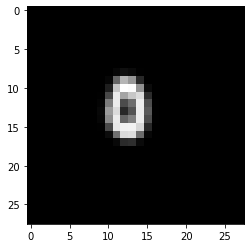

In [7]:
dataset = CustomDataset(
    transform=transforms.Compose([ToGray(),Rescale((28,28))])
)

plt.imshow(dataset[0]['image'],cmap='gray')

In [8]:
dataset_loader = torch.utils.data.DataLoader(
    dataset=dataset, 
    batch_size=1,
)

dataset_iter = iter(dataset_loader)
batch = dataset_iter.next() 

image = batch['image']

In [9]:
model.forward(image.view(image.size(0),-1).float()).argmax()

tensor(4)

We got 0, which is correct. It is not surprising as our accuracy is:

In [10]:
trainer.test()

/home/ardimas/miniconda3/envs/pytorch_tutorial/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1446: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  rank_zero_warn(
Restoring states from the checkpoint path at /home/ardimas/Documents/PROJECTS/pytorch_cv/lightning_logs/version_2/checkpoints/epoch=9-step=5500.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/ardimas/Documents/PROJECTS/pytorch_cv/lightning_logs/version_2/checkpoints/epoch=9-step=5500.ckpt
/home/ardimas/miniconda3/envs/pytorch_tutorial/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a

Testing: 0it [00:00, ?it/s]

/home/ardimas/miniconda3/envs/pytorch_tutorial/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9642000198364258
        test_loss           0.11869892477989197
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.11869892477989197, 'test_acc': 0.9642000198364258}]

# Bonus

As I shared the other day, there is a new type of optimizer, i.e., https://github.com/IssamLaradji/sps

So, let's compare it here.

In [11]:
pl.seed_everything(1412) # --> DON'T FORGET this for consistency 

model = FNN(784, 100, 50, 10, optimizer='sps') # --> NEW

try:
    trainer = pl.Trainer(gpus=1,max_epochs=10)
except Exception as e:
    # most likely due to GPU, so fallback to non GPU
    print(e)
    trainer = pl.Trainer(max_epochs=10)
    
trainer.fit(model)

Global seed set to 1412
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type   | Params
-----------------------------------------
0 | input_layer   | Linear | 78.5 K
1 | hidden_layer1 | Linear | 5.0 K 
2 | output_layer  | Linear | 510   
-----------------------------------------
84.1 K    Trainable params
0         Non-trainable params
84.1 K    Total params
0.336     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/ardimas/miniconda3/envs/pytorch_tutorial/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/ardimas/miniconda3/envs/pytorch_tutorial/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

The accuracy is now:

In [12]:
trainer.test()

Restoring states from the checkpoint path at /home/ardimas/Documents/PROJECTS/pytorch_cv/lightning_logs/version_3/checkpoints/epoch=9-step=5500.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/ardimas/Documents/PROJECTS/pytorch_cv/lightning_logs/version_3/checkpoints/epoch=9-step=5500.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9538999795913696
        test_loss           0.15414927899837494
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.15414927899837494, 'test_acc': 0.9538999795913696}]

Let's compare it using TensorBoard

In [13]:
%tensorboard --logdir lightning_logs/

Reusing TensorBoard on port 6006 (pid 111424), started 0:10:44 ago. (Use '!kill 111424' to kill it.)

The new optimizer is not better than Adam based on our simple experiment. In order to have a more general conclusion, you should investigate more.